# Visualize dsgrid model



In [1]:
import logging
import copy
from enum import Enum, auto
from pathlib import Path
import shutil

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import webcolors

from dsgrid.dataformat.datafile import Datafile
from dsgrid.dataformat.datatable import Datatable
from dsgrid.dataformat.enumeration import census_divisions, conus, conus_states, enumdata_folder
from dsgrid.dataformat.dimmap import mappings
from dsgrid.helpers import ensure_enum, lighten_color, palette
from dsgrid.model import ComponentType, LoadModelComponent, LoadModel

enumdata_folder = Path(enumdata_folder)

from ntbkhelp import OptionPresenter

logger = logging.getLogger(__name__)

def make_dir(p, prompt=True):
    if p.exists():
        return
    if prompt:
        input_str = input(f"{p!r} does not exist. Would you like to create it? [Y/n] ")
        if not (input_str[0].lower() == "y"):
            return
    if not p.parent.exists():
        make_dir(p.parent, prompt=prompt)
    p.mkdir()
    print(f"Created {p!r}.")

## Choose data location

Review the choices in the first cell, select the path you want to use in the second cell, and run both cells.

In [2]:
dsgrid_nrel_base_path_windows = Path("//nrelnas01/PLEXOS/Projects/Load/dsgrid_v0.2.0/")
dsgrid_nrel_base_path_mac = Path("/Volumes/PLEXOS/Projects/Load/dsgrid_v0.2.0/")
dsgrid_oedi_base_path = None

In [3]:
dsgrid_base_path = dsgrid_nrel_base_path_windows

## Specify a local directory for any outputs

Review and edit the specified path. (The default option should be available for most everyone, but feel to change as you see fit.) Review the additional options in the first cell. Then run this section

⚠️ **WARNING** ⚠️ Setting overwrite to True will cause some code to run slower, probably unnecessarily.

In [4]:
# Specify a local directory for any outputs
output_dir = Path.home() / "Documents" / "dsgrid-legacy-efs"

# Plotting code will always overwrite graphics (e.g., 
# .png files) on disk
# 
# If you also want to re-process dsgrid model mappings 
# whenever you run a cell containing such work, 
# set overwrite to True
overwrite = False        # Choices: False, True

# Specify logging level
log_level = logging.INFO # Choices: logging.DEBUG, logging.INFO, logging.WARNING, logging.ERROR, logging.CRITICAL

In [5]:
logging.basicConfig(level=log_level)
    
make_dir(output_dir)

## Helper functions and data for setting up dsgrid models

Run this section

In [6]:
def load_components(datadir,component_type,tuple_list):
    result = []
    for name, color, filepath in tuple_list:
        if not (datadir / filepath).exists():
            logger.info(f'No {name} component in {datadir}')
            continue
        result.append(LoadModelComponent(name,component_type=component_type,color=color))
        result[-1].load_datafile(datadir / filepath)
    return result

# Bottom-Up
bottomup_components_list = [
    ('Residential','#F7A11A','residential.dsg'),
    ('Commercial','#5D9732','commercial.dsg'),
    ('Industrial','#D9531E','industrial.dsg')]

# Gaps
color_fade_frac = 0.3
gap_components_list = [
    ('Residential Gaps',lighten_color(bottomup_components_list[0][1],color_fade_frac),'residential_gaps.dsg'),
    ('Commercial Gaps',lighten_color(bottomup_components_list[1][1],color_fade_frac),'commercial_gaps.dsg'),
    ('Industrial Gaps',lighten_color(bottomup_components_list[2][1],color_fade_frac),'industrial_gaps.dsg'),
    ('Transportation Gaps',lighten_color("#0079C2",color_fade_frac),'trans_rail_hourly.dsg'),
    ('Municipal Water','#00CCCC','municipal_water.dsg'),
    ('Outdoor Lighting','#FFFF33','outdoor_lighting.dsg')]

# DG
dg_components_list = [
    ('CHP and Thermal DG','#99004D','chp_dg.dsg'),
    ('Distributed PV','#CD9B1D','distributedpv_sectoral.dsg'),
    ('Distributed Generation','#99004D','distributed_generation.dsg')]

# Derived
derived_components_list = [
    ('Loss Model','#9A9A9A','loss_model.dsg'),
    ('Hourly Residuals','#632E86','hourly_residuals.dsg')]

# Top-Down
topdown_components_list = [
    ('Top-Down Hourly',None,'historical_hourly_load.dsg'),
    ('Top-Down Annual Energy',None,'eia_annual_energy_by_sector.dsg')]

# informational list of components which use sector_id to differentiate between res, com, ind
# other components either use sector_id to represent subsectors or have a single sector_id
by_sector_components = [
    (ComponentType(ComponentType.TOPDOWN),'Top-Down Annual Energy'),
    (ComponentType(ComponentType.DG),'CHP and Thermal DG'),
    (ComponentType(ComponentType.DG),'Distributed PV')
]

def get_model(model_dir):
    bottomup_components = load_components(model_dir,ComponentType.BOTTOMUP,bottomup_components_list)
    gap_components = load_components(model_dir,ComponentType.GAP,gap_components_list)
    dg_components = load_components(model_dir,ComponentType.DG,dg_components_list)
    derived_components = load_components(model_dir,ComponentType.DERIVED,derived_components_list)
    topdown_components = load_components(model_dir,ComponentType.TOPDOWN,topdown_components_list)
    return LoadModel.create(bottomup_components + gap_components + dg_components + derived_components + topdown_components)

def downselect_model(model,component_keys):
    """
    Parameters
    ----------
    model : dsgrid.LoadModel
    component_keys : list of keys in model.components
        List of component keys in model that are to be KEPT.
        
    Returns
    -------
    dsgrid.LoadModel
        Same object as model. Upon return any components whose keys are not in 
        component_keys will have been deleted.
    """
    to_delete = []
    for key in model.components:
        if key not in component_keys:
            to_delete.append(key)
    for key in to_delete:
        del model.components[key]
    return model

In [7]:
## Helper plotting functions

from ntbkhelp import (model_tz, get_dim_order, add_temporal_category, clean_name, 
                      MatplotlibAxisPosition, enduse_color_map, component_plot, 
                      week_names, prep_for_seasonal_subplots)

# Per https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
# this is supposed to ...
# "Handle date time conversions between pandas and matplotlib"
# ... but it doesn't seem to be helping enough
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


def seasonal_example_weeks_sectors(model, geo_id=None, plots_dir=None, show=False):
    """
    dsgrid Model Documentation Figure 19
    
    Note that this version of the code expects a single geography, either because
    there is only one geography in the dataset (e.g., for CONUS), or because geo_id
    is specified. However, the code was adapted from a different location in which
    geography was looped over and much of that infrastructure (i.e., 
    groupby(['geography'])) remains intact. If you would like to do something similar, 
    at a minimum you will want to change the figure filename to include the value of 
    geo, e.g., f"seasonal_example_weeks_sectors_{geo}.png".
    """
    unit_name = 'GW'
    unit_scale = 1.0E-3
    font_size = 14
    figsize = (8,9.5)
    n_leg_cols = 3
    leg_pos = 8 # 5
    axis_position_kwargs = {
        'ax_lowleft_pos': '0.11,0.16',
        'ax_upright_pos': '0.98,0.98'
    }
    legend_kwargs = {
        'labelspacing': 0.01,
        'handleheight': 1.2,
        'handlelength': 1.2,
        'ncol': n_leg_cols,
        'fontsize': font_size
    }
    plt.style.use(['ggplot'])

    def transform_label(label):
        label = label.replace('Residential','Res.')
        label = label.replace('Commercial','Com.')
        label = label.replace('Industrial','Ind.')
        label = label.replace('Transportation','Trans.')
        if (not label.endswith('Gaps')) and (label.endswith('.')):
            label += ' Sector'
        return label
    
    component_order = [
        (ComponentType(ComponentType.BOTTOMUP),'Residential'),
        (ComponentType(ComponentType.GAP),'Residential Gaps'),
        (ComponentType(ComponentType.BOTTOMUP),'Commercial'),
        (ComponentType(ComponentType.GAP),'Commercial Gaps'),
        (ComponentType(ComponentType.BOTTOMUP),'Industrial'),
        (ComponentType(ComponentType.GAP),'Industrial Gaps'),
        (ComponentType(ComponentType.GAP),'Transportation Gaps'),
        (ComponentType(ComponentType.GAP),'Municipal Water'),
        (ComponentType(ComponentType.GAP),'Outdoor Lighting'),
        (ComponentType(ComponentType.DERIVED),'Loss Model')]
    
    def get_timeseries_by_geography(component, grouped=True):
        result = component.get_datatable(sort=False,verify_integrity=False).data
        if geo_id is not None:
            try:
                result = result.xs(geo_id, level="geography", drop_level=False)
            except:
                logger.info(f"There is no data for {geo_id} in {Path(component.datafile.filepath).name}")
                return None
        result = result.groupby(['geography','time']).sum()
        if grouped:
            result = result.groupby(['geography'])
        return result

    def add_component_data(accumulator, component):
        ts_by_geo = get_timeseries_by_geography(component,grouped=False)
        
        if ts_by_geo is not None:
            if accumulator is None:
                accumulator = ts_by_geo
            else:
                accumulator = accumulator.add(ts_by_geo,fill_value=None)
        return accumulator
    
    top_down_hourly = get_timeseries_by_geography(
        model.components[(ComponentType(ComponentType.TOPDOWN),'Top-Down Hourly')],
        grouped = False)
        
    dg_hourly = None
    for key, component in model.components.items():
        if key[0] == ComponentType(ComponentType.DG):
            dg_hourly = add_component_data(dg_hourly,component)
    dg_hourly = dg_hourly.groupby(['geography','time']).sum().groupby('geography')

    colors = []; columns = []; grouped_data = {}
    for key in component_order:
        component = model.components[key]
        tmp = get_timeseries_by_geography(component, grouped=True)
        if tmp is not None:
            colors.append(component.color)
            columns.append(component.name)
            grouped_data[key] = tmp

    original_figsize = tuple(matplotlib.rcParams['figure.figsize'])
    matplotlib.rcParams['figure.figsize'] = figsize

    axis_position_styler = MatplotlibAxisPosition()

    for geo, ts in top_down_hourly.groupby('geography'):
        if geo_id is not None:
            assert geo == geo_id
        max_ylim = 0.0
        ts.index = ts.index.droplevel()
        dg_ts = dg_hourly.get_group(geo)
        dg_ts.index = dg_ts.index.droplevel()
        ts2 = ts + dg_ts

        # gather all ingredients
        data = []; dropped = []
        for i, key in enumerate(component_order):
            try:
                s = grouped_data[key].get_group(geo)
                s.index = s.index.droplevel()
                data.append(s)
            except: 
                dropped.append(i)
        df = pd.concat(data,axis=1)
        df.columns = [col for i, col in enumerate(columns) if i not in dropped]
        df = prep_for_seasonal_subplots(df)

        ts.name = 'Historical Hourly'
        ts = prep_for_seasonal_subplots(pd.DataFrame(ts))
        ts2.name = 'Hist. Hourly + DG'
        ts2 = prep_for_seasonal_subplots(pd.DataFrame(ts2))

        fig, axx = plt.subplots(4,1)
        first = True
        date_formatter = matplotlib.dates.DateFormatter('%m/%d', tz=model_tz)
        date_locator = matplotlib.dates.DayLocator(tz=model_tz)
        for i, week in enumerate(week_names):
            to_plot = df[df.Season == week]
            del to_plot['Season']
            to_plot = to_plot * unit_scale
            to_plot_colors = [color for i, color in enumerate(colors) if i not in dropped]
            to_plot.plot(ax=axx[i],
                         kind='area',
                         color=to_plot_colors,
                         legend=False)

            ts_to_plot = ts[ts.Season == week]
            del ts_to_plot['Season']
            ts2_to_plot = ts2[ts2.Season == week]
            del ts2_to_plot['Season']
            ts_to_plot = pd.concat([ts_to_plot,ts2_to_plot],axis=1)
            ts_to_plot = ts_to_plot * unit_scale
            ts_to_plot.plot(ax=axx[i],
                            kind='line',
                            style=['k--','k-'],
                            legend=False)

            if first:
                handles, labels = axx[i].get_legend_handles_labels()
                first = False

            axx[i].yaxis.label.set_size(font_size+2)
            axx[i].tick_params(axis='y',labelsize=font_size,colors='k')
            axx[i].set_ylabel(week + ' ({})'.format(unit_name),color='k')
            axx[i].set_xlabel('')
            # This used to work and would be cleaner ... Originally did not require the locator.
            #axx[i].get_xaxis().set_major_locator(date_locator)
            #axx[i].get_xaxis().set_major_formatter(date_formatter)
            axx[i].tick_params(axis='x',labelsize=font_size-4,colors='k')
            axx[i].autoscale(axis='x',tight=True)
            if axx[i].get_ylim()[1] > max_ylim:
                max_ylim = axx[i].get_ylim()[1]
            if ts_to_plot.max().max() > max_ylim:
                max_val = ts_to_plot.max().max()
                ticks = axx[i].get_yticks(minor=False)
                delta_y = (ticks[1] - ticks[0]) / 10.0
                tmp = ticks[-1]
                while tmp < max_val:
                    tmp += delta_y
                max_ylim = tmp

        for i, week in enumerate(week_names):
            axx[i].set_ylim((0.0,max_ylim))
        axis_position_styler.postprocess(fig=fig,ax=axx,**axis_position_kwargs)

        legend = plt.figlegend(handles[::-1],[transform_label(label) for label in labels[::-1]],leg_pos,**legend_kwargs)
        legend.draw_frame(False)

        if plots_dir is not None:
            fig.savefig(plots_dir / "seasonal_example_weeks_sectors.png", dpi=1200)
        if not show:
            plt.close(fig)

    matplotlib.rcParams['figure.figsize'] = original_figsize
    

def seasonal_example_weeks_residuals(model, geo_id=None, plots_dir=None, show=False):
    """
    dsgrid Model Documentation Figure 20
    
    Note that this version of the code expects a single geography, either because
    there is only one geography in the dataset (e.g., for CONUS), or because geo_id
    is specified. However, the code was adapted from a different location in which
    geography was looped over and much of that infrastructure (i.e., 
    groupby(['geography'])) remains intact. If you would like to do something similar, 
    at a minimum you will want to change the figure filename to include the value of 
    geo, e.g., f"seasonal_example_weeks_residuals_{geo}.png".
    """
    fade = 0.25
    columns = ['DG-CHP','DG-PV','Modeled - DG - Overeage','Underage','T&D Losses','Overage']

    unit_name = 'GW'
    unit_scale = 1.0E-3
    font_size = 14
    figsize = (8,9.5)
    n_leg_cols = 2
    leg_pos = 8 # 5
    #axis_position_kwargs = {
    #    'ax_lowleft_pos': '0.08,0.05',
    #    'ax_upright_pos': '0.7,0.95'
    #}
    axis_position_kwargs = {
        'ax_lowleft_pos': '0.11,0.16',
        'ax_upright_pos': '0.98,0.98'
    }
    legend_kwargs = {
        'labelspacing': 0.01,
        'handleheight': 1.2,
        'handlelength': 1.2,
        'ncol': n_leg_cols,
        'fontsize': font_size
    }     
    
    model_components = [
        (ComponentType(ComponentType.BOTTOMUP),'Residential'),
        (ComponentType(ComponentType.GAP),'Residential Gaps'),
        (ComponentType(ComponentType.BOTTOMUP),'Commercial'),
        (ComponentType(ComponentType.GAP),'Commercial Gaps'),
        (ComponentType(ComponentType.BOTTOMUP),'Industrial'),
        (ComponentType(ComponentType.GAP),'Industrial Gaps'),
        (ComponentType(ComponentType.GAP),'Transportation Gaps'),
        (ComponentType(ComponentType.GAP),'Municipal Water'),
        (ComponentType(ComponentType.GAP),'Outdoor Lighting')]

    loss_component = (ComponentType(ComponentType.DERIVED),'Loss Model')

    dg_components = [
        (ComponentType(ComponentType.DG),'CHP and Thermal DG'),
        (ComponentType(ComponentType.DG),'Distributed PV')]
    resid_component = (ComponentType(ComponentType.DERIVED),'Hourly Residuals')
    
    def get_timeseries_by_geography(component, grouped=True):
        result = component.get_datatable(sort=False,verify_integrity=False).data
        if geo_id is not None:
            try:
                result = result.xs(geo_id, level="geography", drop_level=False)
            except:
                logger.info(f"There is no data for {geo_id} in {Path(component.datafile.filepath).name}")
                return None
        result = result.groupby(['geography','time']).sum()
        if grouped:
            result = result.groupby(['geography'])
        return result
    
    def add_component_data(accumulator, component):
        ts_by_geo = get_timeseries_by_geography(component,grouped=False)
        
        if ts_by_geo is not None:
            if accumulator is None:
                accumulator = ts_by_geo
            else:
                accumulator = accumulator.add(ts_by_geo,fill_value=0.0)
        return accumulator

    # calculate modeled portion
    modeled = None
    for key in model_components:
        modeled = add_component_data(modeled, model[key])
    modeled_grouped = modeled.groupby('geography')
    
    # pull and group hourly timeseries, losses, dg - resid
    top_down_hourly = get_timeseries_by_geography(
        model.components[(ComponentType(ComponentType.TOPDOWN),'Top-Down Hourly')], 
        grouped=False)

    loss = get_timeseries_by_geography(model.components[loss_component])
    loss_color = model.components[loss_component].color

    dg = []
    dg_color = []
    for dg_component in dg_components:
        tmp = get_timeseries_by_geography(model.components[dg_component])
        if tmp is not None:
            dg.append(tmp)
            dg_color.append(model.components[dg_component].color)

    resid = get_timeseries_by_geography(model.components[resid_component])
    resid_color = model.components[resid_component].color
    
    colors = dg_color + [lighten_color('#F05A28',fade), lighten_color(resid_color,fade), loss_color, lighten_color(resid_color,fade)]
    
    original_figsize = tuple(matplotlib.rcParams['figure.figsize'])
    matplotlib.rcParams['figure.figsize'] = figsize

    axis_position_styler = MatplotlibAxisPosition()

    def get_series(grouped_data,geo):
        s = grouped_data.get_group(geo)
        s.index = s.index.droplevel()
        return s

    for geo, ts in top_down_hourly.groupby('geography'):
        max_ylim = 0.0
        ts.index = ts.index.droplevel()

        # gather all ingredients
        data = []; dropped = []

        # dg -- 0, 1
        dg_total = None
        for i, dg_type in enumerate(dg):
            candidate = pd.Series(dtype=float)
            try:
                candidate = get_series(dg_type,geo)
            except: pass
            if candidate.empty:
                dropped.append(i)
            else:
                data.append(candidate)
                if dg_total is None:
                    dg_total = copy.deepcopy(data[-1])
                else:
                    dg_total = dg_total.add(data[-1],fill_value=0.0)

        # get and split residuals
        resid_s = get_series(resid,geo)
        neg_resid = resid_s[resid_s.values < 0.0]; pos_resid = resid_s[resid_s.values >= 0.0]

        # modeled - dg - neg_resid -- 2
        modeled_minus_dg = get_series(modeled_grouped,geo).subtract(-neg_resid,fill_value=0.0)
        if dg_total is not None:
            modeled_minus_dg = modeled_minus_dg.subtract(dg_total,fill_value=0.0)
        data.append(modeled_minus_dg)

        # pos_resid -- 3
        if pos_resid.empty:
            dropped.append(3)
        else:
            data.append(pos_resid)

        # losses -- 4
        data.append(get_series(loss,geo))

        # neg_resid -- 5
        if neg_resid.empty:
            dropped.append(5)
        else:
            data.append(-neg_resid)

        df = pd.concat(data,axis=1)
        #df.fillna(value=0.0,inplace=True)
        df.columns = [col for i, col in enumerate(columns) if i not in dropped]
        clrs = [color for i, color in enumerate(colors) if i not in dropped]
        df = prep_for_seasonal_subplots(df)

        # print(pd.concat([dg,get_series(modeled_grouped,geo),modeled_minus_dg],axis=1))

        if dg_total is not None:
            ts = ts.add(dg_total,fill_value=0.0)
        ts.name = 'Hist. Hourly + DG'
        ts = prep_for_seasonal_subplots(pd.DataFrame(ts))

        fig, axx = plt.subplots(4,1)
        first = True
        for i, week in enumerate(week_names):
            to_plot = df[df.Season == week]
            del to_plot['Season']
            to_plot = to_plot * unit_scale
            to_plot.plot(ax=axx[i],
                         kind='area',
                         color=clrs,
                         legend=False)

            ts_to_plot = ts[ts.Season == week]
            del ts_to_plot['Season']
            ts_to_plot = ts_to_plot * unit_scale
            ts_to_plot.plot(ax=axx[i],
                            kind='line',
                            color='k',
                            legend=False)

            if first:
                handles, labels = axx[i].get_legend_handles_labels()
                first = False

            axx[i].yaxis.label.set_size(font_size)
            axx[i].tick_params(axis='y',labelsize=font_size,colors='k')
            axx[i].set_ylabel(week + ' ({})'.format(unit_name),color='k')
            axx[i].set_xlabel('')
            # This used to work and would be cleaner ...
            #axx[i].get_xaxis().set_major_formatter(matplotlib.dates.DateFormatter('%m/%d'))
            axx[i].tick_params(axis='x',labelsize=font_size-4,colors='k')
            axx[i].autoscale(axis='x',tight=True)
            if axx[i].get_ylim()[1] > max_ylim:
                max_ylim = axx[i].get_ylim()[1]
            if ts_to_plot.max().max() > max_ylim:
                max_val = ts_to_plot.max().max()
                ticks = axx[i].get_yticks(minor=False)
                delta_y = (ticks[1] - ticks[0]) / 10.0
                tmp = ticks[-1]
                while tmp < max_val:
                    tmp += delta_y
                max_ylim = tmp

        for i, week in enumerate(week_names):
            axx[i].set_ylim((0.0,max_ylim))
        axis_position_styler.postprocess(fig=fig,ax=axx,**axis_position_kwargs)

        handles = handles[::-1]; labels = labels[::-1]

        legend = plt.figlegend(handles,labels,leg_pos,**legend_kwargs)
        legend.draw_frame(False)

        if plots_dir is not None:
            fig.savefig(plots_dir / "seasonal_example_weeks_residuals.png",dpi=1200)
        if not show:
            plt.close(fig)

    matplotlib.rcParams['figure.figsize'] = original_figsize

    
def seasonal_diurnal_profiles(model, component_id, geo_id=None, plots_dir=None, show=False, 
                              subsector_plot=True, enduse_plot=True, enduse_by_subsector_plots=True,
                              area_plots=True, line_plots=True):
    """
    dsgrid Model Documentation Figures 23, 24, 25
    """
    font_size = 12
    n_leg_cols = 1
    max_subsectors = 15
    
    plot_kwargs = dict(
        font_size = font_size,
        figsize = (6.5,6.5),
        n_leg_cols = n_leg_cols,
        leg_pos = 5,
        axis_position_kwargs = {
            'ax_lowleft_pos': '0.115,0.075',
            'ax_upright_pos': '0.675,0.95'
        },
        legend_kwargs = {
            'labelspacing': 0.02,
            'handleheight': 1.2,
            'handlelength': 1.2,
            'ncol': n_leg_cols,
            'fontsize': font_size-1
        },
        subplots_adjust_kwargs = {
            'hspace': 0.001,
            'wspace': 0.001
        },
        max_subsectors = 15)
    
    plt.style.use(['ggplot'])

    # Get the data to plot
    data = model[component_id].get_datatable(sort=False,verify_integrity=False).data
    if geo_id is not None:
        logger.info(f"Selecting {geo_id} data from {component_id}")
        data = data.xs(geo_id, level="geography", drop_level=False)
    enduses = get_dim_order(data,'enduse'); enduse_enum = model[component_id].datafile.enduse_enum
    logger.info(f"Plotting profiles for {component_id} with enduses {enduses}")
    subsectors = get_dim_order(data,'sector'); sector_enum = model[component_id].datafile.sector_enum
    geographies = get_dim_order(data,'geography'); geo_enum = model[component_id].datafile.geo_enum

    # color palettes
    enduse_colors = palette(model[component_id].color,len(enduses))
    subsector_colors = palette(model[component_id].color,len(subsectors))

    # add temporal information -- season, weekday/weekend, hour 1 to 24
    data.name = 'value'
    data = data.reset_index()
    season_map = pd.read_csv(enumdata_folder / 'hourly2012_to_seasons.csv')
    daytype_map = pd.read_csv(enumdata_folder / 'hourly2012_to_daytypes.csv')
    hours_map = pd.read_csv(enumdata_folder / 'hourly2012_to_hours.csv')
    data = add_temporal_category(data,season_map,'season')
    data = add_temporal_category(data,daytype_map,'day_type')
    data = add_temporal_category(data,hours_map,'hour')
    
    tmp = data.set_index(['sector','geography','enduse','time','season','day_type','hour'])
    tmp = pd.Series(tmp['value'])

    # refresh just for this dataset
    enduses = get_dim_order(tmp,'enduse')
    subsectors = get_dim_order(tmp,'sector')
    enduse_colors = []; tmp = palette(model[component_id].color,len(enduses))
    for i, enduse in enumerate(enduses):
        if enduse in enduse_color_map:
            enduse_colors.append(enduse_color_map[enduse])
        else:
            enduse_colors.append(tmp[i])
    subsector_colors = palette(model[component_id].color,len(subsectors))
    
    component_prefix = component_id[1].lower().replace(' ','-')

    if subsector_plot:
        # plot by subsector
        logger.info("Prepping subsector profiles ...")
        # ... the .sum portion of this step is very slow for detailed components
        logger.info("... aggregating ...")
        to_plot = data.groupby(['time','season','day_type','hour','sector']).sum().reset_index()
        logger.info("... pivoting")
        to_plot = to_plot.pivot_table(values='value',
                                      index=['season','day_type','hour'],
                                      columns='sector',
                                      aggfunc=np.mean)
        to_plot.columns = [col for col in to_plot.columns]
        to_plot = to_plot[subsectors]      

        if len(subsectors) > max_subsectors:
            to_collapse = subsectors[max_subsectors:]
            to_plot['Other'] = to_plot[to_collapse].sum(axis=1)
            for col in to_collapse:
                del to_plot[col]
            subsector_colors = palette(model[component_id].color,max_subsectors+1)

        logger.info("Making subsector plots")
        component_plot(to_plot,subsector_colors,sector_enum,
                       plots_dir,
                       f'{component_prefix}-subsectors-area.png' if area_plots else None, 
                       f'{component_prefix}-subsectors-line.png' if line_plots else None, 
                       show=show, **plot_kwargs)

    # if multiple end-uses
    if len(enduses) > 1:
        if enduse_plot:
            # plot by enduse
            logger.info("Prepping enduse profiles ...")
            # ... the .sum portion of this step is very slow for detailed components
            logger.info("... aggregating ...")
            to_plot = data.groupby(['time','season','day_type','hour','enduse']).sum().reset_index()
            logger.info("... pivoting")
            to_plot = to_plot.pivot_table(values='value',
                                          index=['season','day_type','hour'],
                                          columns='enduse',
                                          aggfunc=np.mean)
            to_plot.columns = [col for col in to_plot.columns]
            to_plot = to_plot[enduses]
            logger.info("Making enduse plots")
            component_plot(to_plot,enduse_colors,enduse_enum,
                           plots_dir,
                           f'{component_prefix}-enduses-area.png' if area_plots else None,
                           f'{component_prefix}-enduses-line.png' if line_plots else None,
                           show=show, **plot_kwargs)

        # if multiple subsectors and end-uses
        if (len(subsectors) > 1) and (len(subsectors) < 30) and enduse_by_subsector_plots:
            # for each subsector
            for subsector in subsectors:
                # plot by enduse
                logger.info(f"Prepping {subsector} enduse profiles ...")
                # ... the .sum portion of this step is very slow for detailed components
                logger.info("... aggregating ...")
                to_plot = data[data.sector == subsector].groupby(['time','season','day_type','hour','enduse']).sum().reset_index()
                logger.info("... pivoting")
                to_plot = to_plot.pivot_table(values='value',
                                              index=['season','day_type','hour'],
                                              columns='enduse',
                                              aggfunc=np.mean)
                to_plot.columns = [col for col in to_plot.columns]
                to_plot = to_plot[enduses]
                subsector_prefix = clean_name(sector_enum.get_name(subsector)).lower().replace(' ', '-')
                logger.info(f"Making {subsector} enduse plots")
                component_plot(to_plot,enduse_colors,enduse_enum,
                               plots_dir,
                               f'{component_prefix}-{subsector_prefix}-enduses-area.png' if area_plots else None,
                               f'{component_prefix}-{subsector_prefix}-enduses-line.png' if line_plots else None,
                               show=show, **plot_kwargs)
    
    return data

## Choose analysis type

Select the analysis_type in the second cell. Then run all cells in this section. If you want to change your analysis_type choice later, just make the change and re-run the second and third cells.

AnalysisType.Residuals enables plots:

- seasonal_example_weeks_sectors (dsgrid Model Documentation Figure 19)
- seasonal_example_weeks_residuals (dsgrid Model Documentation Figure 20)

AnalysisType.Modeled enables plots:

- seasonal_diurnal_profiles (dsgrid Model Documentation Figures 23, 24, 25)

In [8]:
class AnalysisType(Enum):
    Residuals = auto() # modeled components, historical data, and residuals
    Modeled = auto()   # only dsgrid-modeled "bottom-up" and "gap" components

all_components_model_path = dsgrid_base_path / "products" / "state_hourly_residuals"
bottom_up_components_model_path = dsgrid_base_path / "products" / "dsgrid_site_energy_state_hourly"

In [31]:
# Specify which version of the dsgrid data you want to examine
analysis_type = AnalysisType.Modeled # Choices: AnalysisType.Residuals, AnalysisType.Modeled

In [32]:
analysis_type = ensure_enum(AnalysisType, analysis_type)
dsgrid_dataset_path = all_components_model_path if analysis_type == AnalysisType.Residuals else bottom_up_components_model_path

[Choose analysis type](#Choose-analysis-type) | [Contiguous United States](#Contiguous-United-States) | [Census Divisions](#Census-Divisions) | [States](#States)

## Contiguous United States

Run the first cell and then choose a plot type.

Note that with analysis_type == AnalysisType.Residuals, these components are expected to be missing:

- Distributed Generation

and with analysis_type == AnalysisType.Modeled, these components are expected to be missing:

- Residential Gaps (included in Residential in this case)
- CHP and Thermal DG (combined with Distributed PV in Distributed Generation)
- Distributed PV (combined with CHP and Thermal DG in Distributed Generation)
- Loss Model
- Hourly Residuals
- Top-Down Hourly
- Top-Down Annual Energy

In [ ]:
# Create the CONUS model if it does not exist or overwrite is True
model_name = 'conus_hourly_residuals' if analysis_type == AnalysisType.Residuals else "dsgrid_site_energy_conus_hourly"
model_path = output_dir / model_name
if model_path.exists() and overwrite:
    logger.info(f"Deleting {model_path} and re-creating. If this "
                "is not the desired behavior, set overwrite = False.")
    shutil.rmtree(model_path)

if not model_path.exists():
    model = get_model(dsgrid_dataset_path)
    model.map_dimension(model_path, conus, mappings)
model = get_model(model_path)

### Seasonal Example Weeks - Sectors

Requires AnalysisType.Residuals. Produces plots similar to dsgrid Model Documentation Figure 19. 

Be sure to review the show and plots_dir arguments before running.

In [ ]:
assert analysis_type == AnalysisType.Residuals, (f"Wrong analysis_type {analysis_type!r}. To "
    "produce this plot go back to 'Choose analysis type' and input 'AnalysisType.Residuals'; "
    "then re-run the top part of this section before re-running this cell.")

# USER INPUT ----------------------------------------
# 
# Whether to show plots in this notebook
show = True
# Output directory for .png files -- set to None if not desired
plots_dir = output_dir / "seasonal_example_weeks" / "conus"
# ---------------------------------------------------

if plots_dir is not None:
    make_dir(plots_dir)

seasonal_example_weeks_sectors(model, plots_dir=plots_dir, show=show)

[Choose analysis type](#Choose-analysis-type) | [Contiguous United States](#Contiguous-United-States) | [Census Divisions](#Census-Divisions) | [States](#States)

### Seasonal Example Weeks - Residuals

Requires AnalysisType.Residuals. Produces plots similar to dsgrid Model Documentation Figure 20. 

Be sure to review the show and plots_dir arguments before running.

In [ ]:
assert analysis_type == AnalysisType.Residuals, (f"Wrong analysis_type {analysis_type!r}. To "
    "produce this plot go back to 'Choose analysis type' and input 'AnalysisType.Residuals'; "
    "then re-run the top part of this section before re-running this cell.")

# USER INPUT ----------------------------------------
# 
# Whether to show plots in this notebook
show = True
# Output directory for .png files -- set to None if not desired
plots_dir = output_dir / "seasonal_example_weeks" / "conus"
# ---------------------------------------------------

if plots_dir is not None:
    make_dir(plots_dir)
    
seasonal_example_weeks_residuals(model, plots_dir=plots_dir, show=show)

[Choose analysis type](#Choose-analysis-type) | [Contiguous United States](#Contiguous-United-States) | [Census Divisions](#Census-Divisions) | [States](#States)

### Seasonal Diurnal Profiles

Requires AnalysisType.Modeled. Produces plots similar to dsgrid Model Documentation Figures 23, 24, 25. 

Be sure to review the show and plots_dir arguments before running, as well as the True/False options in the call to `seasonal_diurnal_profiles`.

⚠️ **WARNING** ⚠️ This cell can take a long time to run and can produce many figures. Setting show to False and deselecting figure types that are not of interest can mitigate runtime and other issues.

In [ ]:
assert analysis_type == AnalysisType.Modeled, (f"Wrong analysis_type {analysis_type!r}. To "
    "produce these plots go back to 'Choose analysis type' and input 'AnalysisType.Modeled'; "
    "then re-run the top part of this section before re-running this cell.")

# USER INPUT ----------------------------------------
# 
# Whether to show plots in this notebook
show = False
# Output directory for .png files -- set to None if not desired
plots_dir = output_dir / "seasonal_diurnal_profiles" / "conus"
# ---------------------------------------------------

if plots_dir is not None:
    make_dir(plots_dir)

options = OptionPresenter(list(model.keys()))
options.present_options(name_func = lambda x: x[1])
input_str = input("Which component's data would you like to plot (input number)? ")
component_id = options.get_option(input_str)

seasonal_diurnal_profiles(model, component_id, plots_dir = plots_dir, show=show, 
                          subsector_plot=True, enduse_plot=True, enduse_by_subsector_plots=True,
                          area_plots=True, line_plots=True)

[Choose analysis type](#Choose-analysis-type) | [Contiguous United States](#Contiguous-United-States) | [Census Divisions](#Census-Divisions) | [States](#States)

## Census Divisions

Run the first two cells and then choose a plot type.

Note that with analysis_type == AnalysisType.Residuals, these components are expected to be missing:

- Distributed Generation

and with analysis_type == AnalysisType.Modeled, these components are expected to be missing:

- Residential Gaps (included in Residential in this case)
- CHP and Thermal DG (combined with Distributed PV in Distributed Generation)
- Distributed PV (combined with CHP and Thermal DG in Distributed Generation)
- Loss Model
- Hourly Residuals
- Top-Down Hourly
- Top-Down Annual Energy

In [33]:
# Create the Census Divisions model if it does not exist or overwrite is True
model_name = 'census_division_hourly_residuals' if analysis_type == AnalysisType.Residuals else "dsgrid_site_energy_census_division_hourly"
model_path = output_dir / model_name
if model_path.exists() and overwrite:
    logger.info(f"Deleting {model_path} and re-creating. If this "
                "is not the desired behavior, set overwrite = False.")
    shutil.rmtree(model_path)

if not model_path.exists():
    model = get_model(dsgrid_dataset_path)
    model.map_dimension(model_path, census_divisions, mappings)
model = get_model(model_path)

INFO:__main__:No Residential Gaps component in C:\Users\ehale\Documents\dsgrid-legacy-efs\dsgrid_site_energy_census_division_hourly
INFO:__main__:No CHP and Thermal DG component in C:\Users\ehale\Documents\dsgrid-legacy-efs\dsgrid_site_energy_census_division_hourly
INFO:__main__:No Distributed PV component in C:\Users\ehale\Documents\dsgrid-legacy-efs\dsgrid_site_energy_census_division_hourly
INFO:__main__:No Loss Model component in C:\Users\ehale\Documents\dsgrid-legacy-efs\dsgrid_site_energy_census_division_hourly
INFO:__main__:No Hourly Residuals component in C:\Users\ehale\Documents\dsgrid-legacy-efs\dsgrid_site_energy_census_division_hourly
INFO:__main__:No Top-Down Hourly component in C:\Users\ehale\Documents\dsgrid-legacy-efs\dsgrid_site_energy_census_division_hourly
INFO:__main__:No Top-Down Annual Energy component in C:\Users\ehale\Documents\dsgrid-legacy-efs\dsgrid_site_energy_census_division_hourly


In [34]:
geo_enum = model.components[(ComponentType(ComponentType.BOTTOMUP),'Residential')].datafile.geo_enum

options = OptionPresenter(geo_enum.ids)
options.present_options(name_func = geo_enum.get_name)
input_str = input("Which census division would you like to examine (input number)? ")
geo_id = options.get_option(input_str)

 1: East North Central
 2: East South Central
 3: Mid Atlantic
 4: Mountain
 5: New England
 6: Pacific
 7: South Atlantic
 8: West North Central
 9: West South Central
Which census division would you like to examine (input number)? 9


### Seasonal Example Weeks - Sectors

Requires AnalysisType.Residuals. Produces plots similar to dsgrid Model Documentation Figure 19. 

Be sure to review the show and plots_dir arguments before running.

In [35]:
assert analysis_type == AnalysisType.Residuals, (f"Wrong analysis_type {analysis_type!r}. To "
    "produce this plot go back to 'Choose analysis type' and input 'AnalysisType.Residuals'; "
    "then re-run the top part of this section before re-running this cell.")

# USER INPUT ----------------------------------------
# 
# Whether to show plots in this notebook
show = True
# Output directory for .png files -- set to None if not desired
plots_dir = output_dir / "seasonal_example_weeks" / "census_divisions" / geo_id
# ---------------------------------------------------

if plots_dir is not None:
    make_dir(plots_dir)

seasonal_example_weeks_sectors(model, geo_id=geo_id, plots_dir=plots_dir, show=show)

AssertionError: Wrong analysis_type <AnalysisType.Modeled: 2>. To produce this plot go back to 'Choose analysis type' and input 'AnalysisType.Residuals'; then re-run the top part of this section before re-running this cell.

[Choose analysis type](#Choose-analysis-type) | [Contiguous United States](#Contiguous-United-States) | [Census Divisions](#Census-Divisions) | [States](#States)

### Seasonal Example Weeks - Residuals

Requires AnalysisType.Residuals. Produces plots similar to dsgrid Model Documentation Figure 20. 

Be sure to review the show and plots_dir arguments before running.

In [36]:
assert analysis_type == AnalysisType.Residuals, (f"Wrong analysis_type {analysis_type!r}. To "
    "produce this plot go back to 'Choose analysis type' and input 'AnalysisType.Residuals'; "
    "then re-run the top part of this section before re-running this cell.")

# USER INPUT ----------------------------------------
# 
# Whether to show plots in this notebook
show = True
# Output directory for .png files -- set to None if not desired
plots_dir = output_dir / "seasonal_example_weeks" / "census_divisions" / geo_id
# ---------------------------------------------------

if plots_dir is not None:
    make_dir(plots_dir)
    
seasonal_example_weeks_residuals(model, geo_id=geo_id, plots_dir=plots_dir, show=show)

AssertionError: Wrong analysis_type <AnalysisType.Modeled: 2>. To produce this plot go back to 'Choose analysis type' and input 'AnalysisType.Residuals'; then re-run the top part of this section before re-running this cell.

[Choose analysis type](#Choose-analysis-type) | [Contiguous United States](#Contiguous-United-States) | [Census Divisions](#Census-Divisions) | [States](#States)

### Seasonal Diurnal Profiles

Requires AnalysisType.Modeled. Produces plots similar to dsgrid Model Documentation Figures 23, 24, 25. 

Be sure to review the show and plots_dir arguments before running, as well as the True/False options in the call to `seasonal_diurnal_profiles`.

⚠️ **WARNING** ⚠️ This cell can take a long time to run and can produce many figures. Setting show to False and deselecting figure types that are not of interest can mitigate runtime and other issues.

In [37]:
assert analysis_type == AnalysisType.Modeled, (f"Wrong analysis_type {analysis_type!r}. To "
    "produce these plots go back to 'Choose analysis type' and input 'AnalysisType.Modeled'; "
    "then re-run the top part of this section before re-running this cell.")

# USER INPUT ----------------------------------------
# 
# Whether to show plots in this notebook
show = False
# Output directory for .png files -- set to None if not desired
plots_dir = output_dir / "seasonal_diurnal_profiles" / "census_divisions" / geo_id
# ---------------------------------------------------

if plots_dir is not None:
    make_dir(plots_dir)

options = OptionPresenter(list(model.keys()))
options.present_options(name_func = lambda x: x[1])
input_str = input("Which component's data would you like to plot (input number)? ")
component_id = options.get_option(input_str)

seasonal_diurnal_profiles(model, component_id, geo_id=geo_id, plots_dir=plots_dir, show=show, 
                          subsector_plot=True, enduse_plot=True, enduse_by_subsector_plots=True,
                          area_plots=True, line_plots=True)

WindowsPath('C:/Users/ehale/Documents/dsgrid-legacy-efs/seasonal_diurnal_profiles/census_divisions/west_south_central') does not exist. Would you like to create it? [Y/n] Y
Created WindowsPath('C:/Users/ehale/Documents/dsgrid-legacy-efs/seasonal_diurnal_profiles/census_divisions/west_south_central').
 1: Residential
 2: Commercial
 3: Industrial
 4: Commercial Gaps
 5: Industrial Gaps
 6: Transportation Gaps
 7: Municipal Water
 8: Outdoor Lighting
 9: Distributed Generation
Which component's data would you like to plot (input number)? 5


INFO:__main__:Selecting west_south_central data from (<ComponentType.GAP: 2>, 'Industrial Gaps')
INFO:__main__:Plotting profiles for (<ComponentType.GAP: 2>, 'Industrial Gaps') with enduses ['energy_consumption']
INFO:__main__:Prepping subsector profiles ...
INFO:__main__:... aggregating ...
INFO:__main__:... pivoting
INFO:__main__:Making subsector plots


,sector,geography,enduse,time,value,season,day_type,hour
0,11,west_south_central,energy_consumption,2012-01-01 01:00:00-05:00,205.105591,winter,weekend,1
1,11,west_south_central,energy_consumption,2012-01-01 02:00:00-05:00,204.996277,winter,weekend,2
2,11,west_south_central,energy_consumption,2012-01-01 03:00:00-05:00,205.172119,winter,weekend,3
3,11,west_south_central,energy_consumption,2012-01-01 04:00:00-05:00,205.665741,winter,weekend,4
4,11,west_south_central,energy_consumption,2012-01-01 05:00:00-05:00,206.509644,winter,weekend,5
...,...,...,...,...,...,...,...,...
26347,23,west_south_central,energy_consumption,2012-12-31 20:00:00-05:00,1265.226196,winter,weekday,20
26348,23,west_south_central,energy_consumption,2012-12-31 21:00:00-05:00,1247.317261,winter,weekday,21
26349,23,west_south_central,energy_consumption,2012-12-31 22:00:00-05:00,1237.936279,winter,weekday,22
26350,23,west_south_central,energy_consumption,2012-12-31 23:00:00-05:00,1216.487061,winter,weekday,23


[Choose analysis type](#Choose-analysis-type) | [Contiguous United States](#Contiguous-United-States) | [Census Divisions](#Census-Divisions) | [States](#States)

## States

Run the first two cells and then choose a plot type.

Note that with analysis_type == AnalysisType.Residuals, these components are expected to be missing:

- Distributed Generation

and with analysis_type == AnalysisType.Modeled, these components are expected to be missing:

- Residential Gaps (included in Residential in this case)
- CHP and Thermal DG (combined with Distributed PV in Distributed Generation)
- Distributed PV (combined with CHP and Thermal DG in Distributed Generation)
- Loss Model
- Hourly Residuals
- Top-Down Hourly
- Top-Down Annual Energy

In [18]:
model = get_model(dsgrid_dataset_path)

INFO:__main__:No Distributed Generation component in \\nrelnas01\PLEXOS\Projects\Load\dsgrid_v0.2.0\products\state_hourly_residuals


In [19]:
geo_enum = conus_states

options = OptionPresenter(geo_enum.ids)
options.present_options(name_func = geo_enum.get_name)
input_str = input("Which state would you like to examine (input number)? ")
geo_id = options.get_option(input_str)

  1: Alabama
  2: Arkansas
  3: Arizona
  4: California
  5: Colorado
  6: Connecticut
  7: District of Columbia
  8: Delaware
  9: Florida
 10: Georgia
 11: Iowa
 12: Idaho
 13: Illinois
 14: Indiana
 15: Kansas
 16: Kentucky
 17: Louisiana
 18: Massachusetts
 19: Maryland
 20: Maine
 21: Michigan
 22: Minnesota
 23: Missouri
 24: Mississippi
 25: Montana
 26: North Carolina
 27: North Dakota
 28: Nebraska
 29: New Hampshire
 30: New Jersey
 31: New Mexico
 32: Nevada
 33: New York
 34: Ohio
 35: Oklahoma
 36: Oregon
 37: Pennsylvania
 38: Rhode Island
 39: South Carolina
 40: South Dakota
 41: Tennessee
 42: Texas
 43: Utah
 44: Virginia
 45: Vermont
 46: Washington
 47: Wisconsin
 48: West Virginia
 49: Wyoming
Which state would you like to examine (input number)? 9


### Seasonal Example Weeks - Sectors

Requires AnalysisType.Residuals. Produces plots similar to dsgrid Model Documentation Figure 19. 

Be sure to review the show and plots_dir arguments before running.

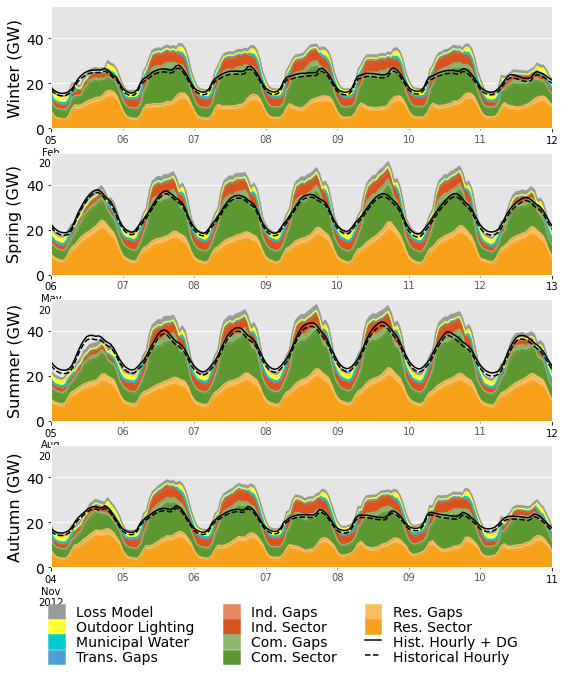

In [25]:
assert analysis_type == AnalysisType.Residuals, (f"Wrong analysis_type {analysis_type!r}. To "
    "produce this plot go back to 'Choose analysis type' and input 'AnalysisType.Residuals'; "
    "then re-run the top part of this section before re-running this cell.")

# USER INPUT ----------------------------------------
# 
# Whether to show plots in this notebook
show = True
# Output directory for .png files -- set to None if not desired
plots_dir = output_dir / "seasonal_example_weeks" / "states" / geo_id
# ---------------------------------------------------

if plots_dir is not None:
    make_dir(plots_dir)

seasonal_example_weeks_sectors(model, geo_id=geo_id, plots_dir=plots_dir, show=show)

[Choose analysis type](#Choose-analysis-type) | [Contiguous United States](#Contiguous-United-States) | [Census Divisions](#Census-Divisions) | [States](#States)

### Seasonal Example Weeks - Residuals

Requires AnalysisType.Residuals. Produces plots similar to dsgrid Model Documentation Figure 20. 

Be sure to review the show and plots_dir arguments before running.

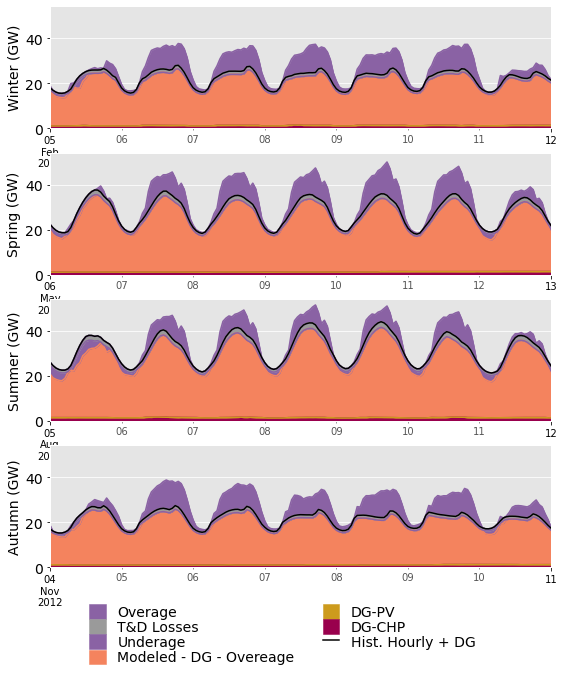

In [24]:
assert analysis_type == AnalysisType.Residuals, (f"Wrong analysis_type {analysis_type!r}. To "
    "produce this plot go back to 'Choose analysis type' and input 'AnalysisType.Residuals'; "
    "then re-run the top part of this section before re-running this cell.")

# USER INPUT ----------------------------------------
# 
# Whether to show plots in this notebook
show = True
# Output directory for .png files -- set to None if not desired
plots_dir = output_dir / "seasonal_example_weeks" / "states" / geo_id
# ---------------------------------------------------

if plots_dir is not None:
    make_dir(plots_dir)
    
seasonal_example_weeks_residuals(model, geo_id=geo_id, plots_dir=plots_dir, show=show)

[Choose analysis type](#Choose-analysis-type) | [Contiguous United States](#Contiguous-United-States) | [Census Divisions](#Census-Divisions) | [States](#States)

### Seasonal Diurnal Profiles

Requires AnalysisType.Modeled. Produces plots similar to dsgrid Model Documentation Figures 23, 24, 25. 

Be sure to review the show and plots_dir arguments before running, as well as the True/False options in the call to `seasonal_diurnal_profiles`.

⚠️ **WARNING** ⚠️ This cell can take a long time to run and can produce many figures. Setting show to False and deselecting figure types that are not of interest can mitigate runtime and other issues.

In [23]:
assert analysis_type == AnalysisType.Modeled, (f"Wrong analysis_type {analysis_type!r}. To "
    "produce these plots go back to 'Choose analysis type' and input 'AnalysisType.Modeled'; "
    "then re-run the top part of this section before re-running this cell.")

# USER INPUT ----------------------------------------
# 
# Whether to show plots in this notebook
show = False
# Output directory for .png files -- set to None if not desired
plots_dir = output_dir / "seasonal_diurnal_profiles" / "states" / geo_id
# ---------------------------------------------------

if plots_dir is not None:
    make_dir(plots_dir)

options = OptionPresenter(list(model.keys()))
options.present_options(name_func = lambda x: x[1])
input_str = input("Which component's data would you like to plot (input number)? ")
component_id = options.get_option(input_str)

seasonal_diurnal_profiles(model, component_id, geo_id=geo_id, plots_dir=plots_dir, show=show, 
                          subsector_plot=True, enduse_plot=True, enduse_by_subsector_plots=True,
                          area_plots=True, line_plots=True)

AssertionError: Wrong analysis_type <AnalysisType.Residuals: 1>. To produce these plots go back to 'Choose analysis type' and input 'AnalysisType.Modeled'; then re-run the top part of this section before re-running this cell.

[Choose analysis type](#Choose-analysis-type) | [Contiguous United States](#Contiguous-United-States) | [Census Divisions](#Census-Divisions) | [States](#States)